#### Trump Hate on Twitter

Implement Gaussian process regression discontinuity design for Trump hate data.

Siegel, Alexandra A., et al. "Trumping hate on Twitter? Online hate speech in the 2016 US election campaign and its aftermath." Quarterly Journal of Political Science 16.1 (2021): 71-104.



In [1]:
# load gpytoch and other packages
import torch
import numpy as np
import pandas as pd
import gpytorch
from scipy.stats import norm
from typing import Optional, Tuple
from matplotlib import pyplot as plt
from gpytorch.means import LinearMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(12345)

load daily proportion of white nationalist on randomly sampled tweets between June 2015 to June 2017

In [2]:
# read data
data = pd.read_csv("./data/white_nationalist_random.csv")

# format date as datatime
# and turn date into time index
xs = data.date
xs = xs.apply(lambda x: (datetime.strptime(x,"%Y-%m-%d")-datetime.strptime(xs[0],"%Y-%m-%d")).days)
ys_scale = 1e5
ys = torch.tensor(data.norm_hate.values).double() * ys_scale
# xs: time, election indicator, time * election indicator
xs = torch.tensor(np.array([xs.values, data.election.values]).T)
xs = torch.cat((xs, (xs[:,0]*xs[:,1]).reshape(-1,1)), dim=1).double()

election_day_index = np.where(xs[:,1])[0][0]

we build a Gaussian process regression model with an automatic relevance determination RBF kernel:
$$
f(t,D) \sim\mathcal{GP}(\beta_0+\beta_1 t + \beta_2 D + \beta_3 Dt,K)
$$
The mean function includes a baseline intercept $\beta_0$, a pre-election linear time effect $\beta_1$, an instanteneous change at election $\beta_2$ and a post-election linear time effect $\beta_3+\beta_1$. The covariance function allows non-linear deviation of the daily proportions from the linear trend.

In [3]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # constant country-level mean
        self.mean_module = LinearMean(input_size=3, bias=True)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=3))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

now we initialize the model and use `Adam()` optimizer to learn the hyperparameters.

In [40]:
likelihood = GaussianLikelihood()
model = GPModel(xs, ys, likelihood).double()

# initialize model parameters
hypers = {
    'mean_module.bias': torch.tensor([0.]),
    'mean_module.weights': torch.tensor([0.,0.,0.]),
    'covar_module.outputscale': torch.var(ys),
    'covar_module.base_kernel.lengthscale': torch.tensor([90.,10, 90.]), # initialize with quarterly change
    'likelihood.noise': torch.var(ys),
}    

model = model.initialize(**hypers)

# train model
model.train()
likelihood.train()

all_params = set(model.parameters())
optimizer = torch.optim.Adam(all_params, lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 400
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(xs)
    loss = -mll(output, ys)
    loss.backward()
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f '  % (
            i , training_iter, loss.item()
        ))
    optimizer.step()

Iter 0/400 - Loss: -0.188 
Iter 10/400 - Loss: 128.527 
Iter 20/400 - Loss: 40.455 
Iter 30/400 - Loss: 11.787 
Iter 40/400 - Loss: 3.927 
Iter 50/400 - Loss: 1.308 
Iter 60/400 - Loss: 0.398 
Iter 70/400 - Loss: 0.111 
Iter 80/400 - Loss: 0.044 
Iter 90/400 - Loss: 0.032 
Iter 100/400 - Loss: 0.013 
Iter 110/400 - Loss: -0.013 
Iter 120/400 - Loss: -0.036 
Iter 130/400 - Loss: -0.055 
Iter 140/400 - Loss: -0.073 
Iter 150/400 - Loss: -0.090 
Iter 160/400 - Loss: -0.105 
Iter 170/400 - Loss: -0.119 
Iter 180/400 - Loss: -0.131 
Iter 190/400 - Loss: -0.141 
Iter 200/400 - Loss: -0.150 
Iter 210/400 - Loss: -0.157 
Iter 220/400 - Loss: -0.163 
Iter 230/400 - Loss: -0.168 
Iter 240/400 - Loss: -0.171 
Iter 250/400 - Loss: -0.174 
Iter 260/400 - Loss: -0.176 
Iter 270/400 - Loss: -0.177 
Iter 280/400 - Loss: -0.178 
Iter 290/400 - Loss: -0.179 
Iter 300/400 - Loss: -0.179 
Iter 310/400 - Loss: -0.179 
Iter 320/400 - Loss: -0.179 
Iter 330/400 - Loss: -0.180 
Iter 340/400 - Loss: -0.180 
It

visualize the posterior

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


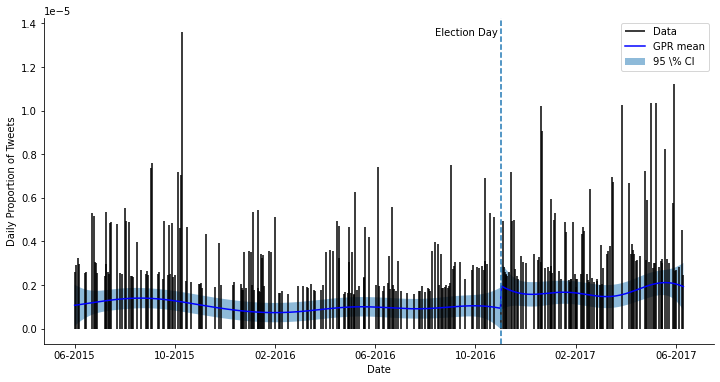

In [41]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(xs)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f/ys_scale})
results['true_y'] = ys/ys_scale
results['gpr_lwr'] = lower/ys_scale
results['gpr_upr'] = upper/ys_scale
results['day'] = xs[:,0].numpy().astype(int)
results.to_csv("./results/TrumpHate_fitted_gpr.csv",index=False) #save to file

f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.vlines(xs[:,0].numpy(), 0*ys.numpy(), ys.numpy()/ys_scale, colors='k')
ax.plot(xs[:,0].numpy(), out.mean.numpy()/ys_scale, 'b')
ax.fill_between(xs[:,0].numpy(), lower.numpy()/ys_scale, upper.numpy()/ys_scale, alpha=0.5)
ax.axvline(x=election_day_index, ls="--")
ax.text(election_day_index-80, ys.numpy().max()/ys_scale, "Election Day", rotation=0, verticalalignment='center')
ax.legend(['Data', 'GPR mean', '95 \% CI'])
ax.set_xlabel("Date")
ax.set_ylabel("Daily Proportion of Tweets")
ax.set_xticks(np.arange(xs[:,0].min().data,xs[:,0].max().data,120))
ax.set_xticklabels(["06-2015","10-2015","02-2016","06-2016","10-2016","02-2017","06-2017"])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

use `autograd` to compute gradients of daily porportion w.r.t inputs

In [42]:
model.eval()
likelihood.eval()

# number of empirically sample 
n_samples = 100
x_grad = np.zeros((xs.size(0),xs.size(1)))
sampled_dydtest_x = np.zeros((n_samples, xs.size(0),xs.size(1)))

# we proceed in small batches of size 100 for speed up
for i in range(xs.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = xs[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = model(test_x)
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), \
                                    test_x, retain_graph=True)[0] for pred in sampled_pred])
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = xs[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = model(test_x)
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(),\
                                     test_x, retain_graph=True)[0] for pred in sampled_pred])
    

/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  NumericalWarning,


posterior of slope parameters ( $\beta_1$ and $\beta_3$)

In [62]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).var(0) + \
                  sampled_dydtest_x.var(1).mean(0)).round(decimals=5)
covariate_names = ["pre", "post minus pred"]
results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[[0,2]]/ys_scale,
                        'est_std': est_std[[0,2]]/ys_scale})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

                 x      est_mean       est_std         t    pvalue
0              pre -4.375156e-10  6.725000e-07 -0.000651  0.499740
1  post minus pred  1.300258e-09  2.605000e-07  0.004991  0.498009


posterior of instaneous change on Election Day

In [74]:
model.eval()
likelihood.eval()

# copy training tesnor to test tensors and set AIshame to 1 and 0
test_x = xs[(election_day_index-1):(election_day_index+1)].clone().detach().requires_grad_(False)

# in eval mode the forward() function returns posterioir
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(test_x)

# compute ATE of election and its uncertainty
effect = out.mean.numpy()[1] - out.mean.numpy()[0]
effect_std = np.sqrt((out.covariance_matrix.diag().detach().numpy()[0]+\
                      out.covariance_matrix.diag().detach().numpy()[1]))
print("instaneous shift on Election Day: {:.2E} +- {:.2E}\n".format(effect/ys_scale, effect_std/ys_scale))
BIC = (4+3+1)*torch.log(torch.tensor(xs.size()[0])) + 2*loss*xs.size()[0]
print("model evidence: {:0.3f} \n".format(-loss*xs.size()[0]))
print("BIC: {:0.3f} \n".format(BIC))

instaneous shift on Election Day: 1.02E-06 +- 7.20E-07

model evidence: 131.257 

BIC: -209.770 



compare with linear model

In [75]:
import statsmodels.formula.api as sm

data["time_index"] = xs[:,0].numpy()
lm = sm.ols('norm_hate ~ time_index + election + time_index:election', data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              norm_hate   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     7.100
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           0.000105
Time:                        10:56:44   Log-Likelihood:                 8560.9
No. Observations:                 730   AIC:                        -1.711e+04
Df Residuals:                     726   BIC:                        -1.710e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              1.2e-06   1